## 1. Setup and Imports

In [28]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
from itertools import product

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Standard libraries loaded")

✓ Standard libraries loaded


In [29]:
# Add parent directory to path for imports
import sys
sys.path.insert(0, '../')

# Import project modules
from src.data_loader import load_wine_quality, preprocess_data, split_data

print("✓ Project modules loaded")

✓ Project modules loaded


In [30]:
# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc

print("✓ Scikit-learn modules loaded")

✓ Scikit-learn modules loaded


In [31]:
# Create results directories
RESULTS_DIR = Path('../results/regularization_conditioned')
FIGURES_DIR = RESULTS_DIR / 'figures'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Results directory: {RESULTS_DIR}")
print(f"✓ Figures directory: {FIGURES_DIR}")

✓ Results directory: ../results/regularization_conditioned
✓ Figures directory: ../results/regularization_conditioned/figures


In [32]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"✓ Random seed set to {RANDOM_STATE}")

✓ Random seed set to 42


## 2. Load Wine Quality Dataset

In [33]:
# Load the wine quality dataset
print("Loading Wine Quality dataset...")
X, y = load_wine_quality()
feature_names = X.columns.tolist()

print(f"\n✓ Dataset loaded successfully!")
print(f"  Samples: {X.shape[0]}")
print(f"  Features: {X.shape[1]}")
print(f"  Feature names: {feature_names}")

Loading Wine Quality dataset...
Wine Quality Dataset loaded: 6497 samples, 12 features
Class distribution: {0: 5220, 1: 1277}

✓ Dataset loaded successfully!
  Samples: 6497
  Features: 12
  Feature names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'wine_type']


In [34]:
# Preprocess data
X_processed, y_processed = preprocess_data(X, y)

print(f"Class distribution:")
unique, counts = np.unique(y_processed, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} ({count/len(y_processed)*100:.1f}%)")

Class distribution:
  Class 0: 5220 (80.3%)
  Class 1: 1277 (19.7%)


In [35]:
# Split into train/test sets (same split as other notebooks)
X_train, X_test, y_train, y_test = split_data(
    X, y_processed, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print(f"\n✓ Data split complete:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")


Data split: 5197 train, 1300 test samples
Train class distribution: {0: 4176, 1: 1021}
Test class distribution: {0: 1044, 1: 256}

✓ Data split complete:
  Training samples: 5197
  Test samples: 1300


## 3. Define Experimental Grid

### 3.1 Scaler and Regularization Configurations

In [36]:
# Define scalers
scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler(),
    'MaxAbs': MaxAbsScaler()
}

# Define regularization strengths (C values)
# Lower C = stronger regularization, Higher C = weaker regularization
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

print("Experimental Configuration:")
print(f"  Scalers: {list(scalers.keys())}")
print(f"  C values: {C_values}")
print(f"  Total combinations: {len(scalers)} × {len(C_values)} = {len(scalers) * len(C_values)}")

Experimental Configuration:
  Scalers: ['Standard', 'MinMax', 'Robust', 'MaxAbs']
  C values: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
  Total combinations: 4 × 6 = 24


## 4. Train Models Across Scaler × Regularization Grid

### 4.1 Cartesian Product Training

In [37]:
# Train all scaler-C combinations
print("Training models across Scaler × Regularization grid...")
print("="*80)

results = []
models = {}
training_times = {}

total_combinations = len(scalers) * len(C_values)
current = 0

for scaler_name, scaler in scalers.items():
    for C in C_values:
        current += 1
        model_id = f"{scaler_name}_C{C}"
        
        print(f"[{current}/{total_combinations}] Training {scaler_name} with C={C}...")
        
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', scaler),
            ('classifier', LogisticRegression(
                C=C,
                max_iter=1000,
                random_state=RANDOM_STATE,
                solver='lbfgs'
            ))
        ])
        
        # Train
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Predict
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = pipeline.predict(X_test)
        
        # Store results
        result = {
            'scaler': scaler_name,
            'C': C,
            'model_id': model_id,
            'auc_roc': roc_auc_score(y_test, y_pred_proba),
            'pr_auc': average_precision_score(y_test, y_pred_proba),
            'accuracy': accuracy_score(y_test, y_pred),
            'training_time': training_time
        }
        results.append(result)
        models[model_id] = pipeline
        training_times[model_id] = training_time
        
        print(f"  AUC-ROC: {result['auc_roc']:.4f}, "
              f"PR AUC: {result['pr_auc']:.4f}, "
              f"Accuracy: {result['accuracy']:.4f}")

results_df = pd.DataFrame(results)

print("="*80)
print(f"\n✓ Training complete! Total time: {sum(training_times.values()):.2f}s")
print(f"  Average time per model: {np.mean(list(training_times.values())):.3f}s")

Training models across Scaler × Regularization grid...
[1/24] Training Standard with C=0.001...
  AUC-ROC: 0.7869, PR AUC: 0.5105, Accuracy: 0.8038
[2/24] Training Standard with C=0.01...
  AUC-ROC: 0.8014, PR AUC: 0.5335, Accuracy: 0.8262
[3/24] Training Standard with C=0.1...
  AUC-ROC: 0.8040, PR AUC: 0.5322, Accuracy: 0.8231
[4/24] Training Standard with C=1.0...
  AUC-ROC: 0.8048, PR AUC: 0.5249, Accuracy: 0.8223
[5/24] Training Standard with C=10.0...
  AUC-ROC: 0.8050, PR AUC: 0.5256, Accuracy: 0.8223
[6/24] Training Standard with C=100.0...
  AUC-ROC: 0.8050, PR AUC: 0.5255, Accuracy: 0.8223
[7/24] Training MinMax with C=0.001...
  AUC-ROC: 0.7199, PR AUC: 0.4669, Accuracy: 0.8031
[8/24] Training MinMax with C=0.01...
  AUC-ROC: 0.7531, PR AUC: 0.4813, Accuracy: 0.8031
[9/24] Training MinMax with C=0.1...
  AUC-ROC: 0.7846, PR AUC: 0.5074, Accuracy: 0.8131
[10/24] Training MinMax with C=1.0...
  AUC-ROC: 0.7988, PR AUC: 0.5293, Accuracy: 0.8262
[11/24] Training MinMax with C=10

In [38]:
# Display results summary
print("\nResults Summary:")
print("="*80)
display(results_df.round(4))
print("="*80)


Results Summary:


,scaler,C,model_id,auc_roc,pr_auc,accuracy,training_time
0,Standard,0.001,Standard_C0.001,0.7869,0.5105,0.8038,0.0078
1,Standard,0.010,Standard_C0.01,0.8014,0.5335,0.8262,0.0248
2,Standard,0.100,Standard_C0.1,0.8040,0.5322,0.8231,0.0076
3,Standard,1.000,Standard_C1.0,0.8048,0.5249,0.8223,0.0092
4,Standard,10.000,Standard_C10.0,0.8050,0.5256,0.8223,0.0076
5,Standard,100.000,Standard_C100.0,0.8050,0.5255,0.8223,0.0076
6,MinMax,0.001,MinMax_C0.001,0.7199,0.4669,0.8031,0.0048
7,MinMax,0.010,MinMax_C0.01,0.7531,0.4813,0.8031,0.0056
8,MinMax,0.100,MinMax_C0.1,0.7846,0.5074,0.8131,0.0080
9,MinMax,1.000,MinMax_C1.0,0.7988,0.5293,0.8262,0.0087


### 4.2 Analyze Performance Patterns

In [39]:
# Find best model overall
best_idx = results_df['auc_roc'].idxmax()
best_model = results_df.loc[best_idx]

print("Best Model (by AUC-ROC):")
print(f"  Scaler: {best_model['scaler']}")
print(f"  C: {best_model['C']}")
print(f"  AUC-ROC: {best_model['auc_roc']:.4f}")
print(f"  PR AUC: {best_model['pr_auc']:.4f}")
print(f"  Accuracy: {best_model['accuracy']:.4f}")

Best Model (by AUC-ROC):
  Scaler: Robust
  C: 100.0
  AUC-ROC: 0.8050
  PR AUC: 0.5257
  Accuracy: 0.8223


In [40]:
# Analyze: Best scaler at each C value
print("\nBest Scaler at Each Regularization Strength:")
print("="*80)

best_at_C = []
for C in C_values:
    subset = results_df[results_df['C'] == C]
    best_idx = subset['auc_roc'].idxmax()
    best = subset.loc[best_idx]
    best_at_C.append({
        'C': C,
        'best_scaler': best['scaler'],
        'auc_roc': best['auc_roc']
    })
    print(f"C = {C:7.3f}: {best['scaler']:8s} (AUC-ROC: {best['auc_roc']:.4f})")

best_at_C_df = pd.DataFrame(best_at_C)
print("="*80)


Best Scaler at Each Regularization Strength:
C =   0.001: Standard (AUC-ROC: 0.7869)
C =   0.010: Robust   (AUC-ROC: 0.8016)
C =   0.100: Standard (AUC-ROC: 0.8040)
C =   1.000: Standard (AUC-ROC: 0.8048)
C =  10.000: Standard (AUC-ROC: 0.8050)
C = 100.000: Robust   (AUC-ROC: 0.8050)


In [41]:
# Analyze: Best C for each scaler
print("\nBest Regularization Strength for Each Scaler:")
print("="*80)

best_C_for_scaler = []
for scaler_name in scalers.keys():
    subset = results_df[results_df['scaler'] == scaler_name]
    best_idx = subset['auc_roc'].idxmax()
    best = subset.loc[best_idx]
    best_C_for_scaler.append({
        'scaler': scaler_name,
        'best_C': best['C'],
        'auc_roc': best['auc_roc']
    })
    print(f"{scaler_name:8s}: C = {best['C']:7.3f} (AUC-ROC: {best['auc_roc']:.4f})")

best_C_df = pd.DataFrame(best_C_for_scaler)
print("="*80)


Best Regularization Strength for Each Scaler:
Standard: C =  10.000 (AUC-ROC: 0.8050)
MinMax  : C = 100.000 (AUC-ROC: 0.8044)
Robust  : C = 100.000 (AUC-ROC: 0.8050)
MaxAbs  : C = 100.000 (AUC-ROC: 0.8007)


## 5. Visualize Scaler × Regularization Interactions

### 5.1 Heatmap: Performance Across Grid

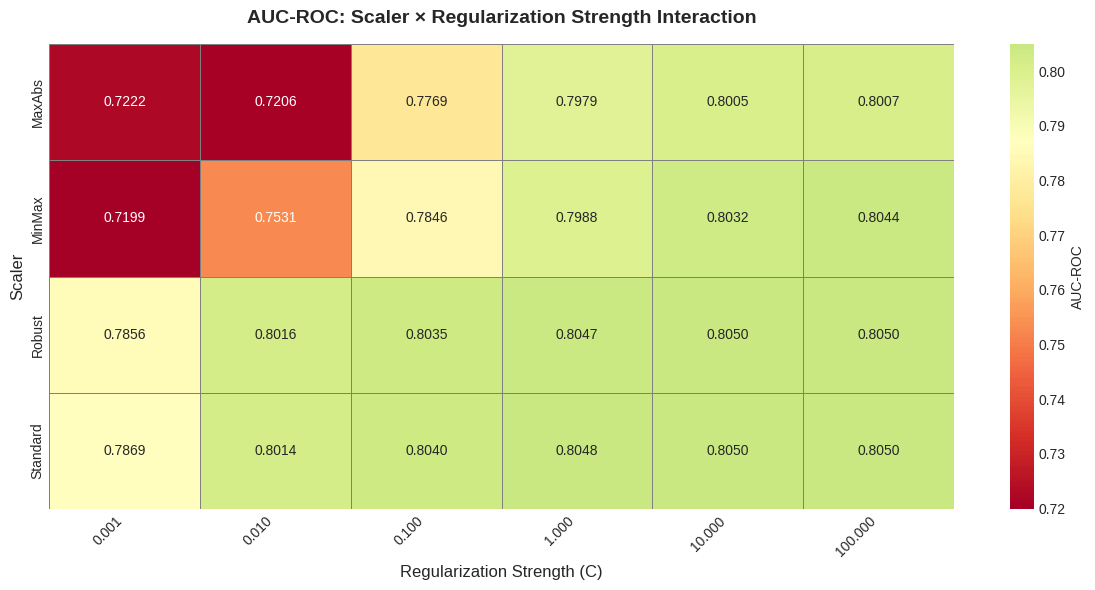

✓ Heatmap saved to ../results/regularization_conditioned/figures/scaler_regularization_heatmap.png


In [42]:
# Create pivot table for heatmap
pivot_auc = results_df.pivot(index='scaler', columns='C', values='auc_roc')

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(pivot_auc, annot=True, fmt='.4f', cmap='RdYlGn', 
            center=pivot_auc.values.mean(), vmin=pivot_auc.values.min(), vmax=pivot_auc.values.max(),
            linewidths=0.5, linecolor='gray', ax=ax,
            cbar_kws={'label': 'AUC-ROC'})

ax.set_title('AUC-ROC: Scaler × Regularization Strength Interaction', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Regularization Strength (C)', fontsize=12)
ax.set_ylabel('Scaler', fontsize=12)
ax.set_xticklabels([f'{c:.3f}' for c in C_values], rotation=45, ha='right')

plt.tight_layout()
save_path = FIGURES_DIR / 'scaler_regularization_heatmap.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Heatmap saved to {save_path}")

### 5.2 Line Plot: Performance Trajectories

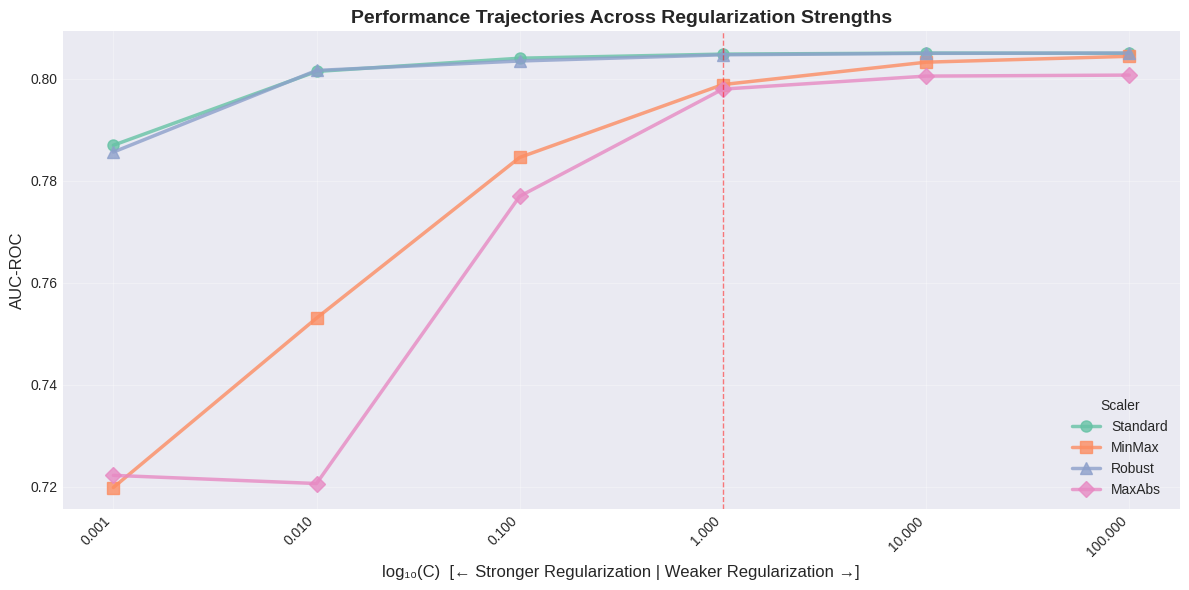

✓ Trajectories plot saved to ../results/regularization_conditioned/figures/performance_trajectories.png


In [43]:
# Plot performance trajectories across C values
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Set2(range(len(scalers)))
markers = ['o', 's', '^', 'D']

for idx, scaler_name in enumerate(scalers.keys()):
    subset = results_df[results_df['scaler'] == scaler_name].sort_values('C')
    ax.plot(np.log10(subset['C']), subset['auc_roc'], 
            marker=markers[idx], markersize=8, linewidth=2.5, alpha=0.8,
            color=colors[idx], label=scaler_name)

ax.set_xlabel('log₁₀(C)  [← Stronger Regularization | Weaker Regularization →]', fontsize=12)
ax.set_ylabel('AUC-ROC', fontsize=12)
ax.set_title('Performance Trajectories Across Regularization Strengths', 
             fontsize=14, fontweight='bold')
ax.legend(title='Scaler', loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Add vertical line at C=1 (no regularization bias)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='C=1')

# Set x-tick labels
ax.set_xticks(np.log10(C_values))
ax.set_xticklabels([f'{c:.3f}' for c in C_values], rotation=45, ha='right')

plt.tight_layout()
save_path = FIGURES_DIR / 'performance_trajectories.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Trajectories plot saved to {save_path}")

## 6. Build Regularization-Conditioned Ensembles

### 6.1 Strategy 1: Uniform Ensemble (All Models)

In [44]:
# Create predictions from all models
all_predictions = []
model_ids = []

for model_id, pipeline in models.items():
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    all_predictions.append(y_pred_proba)
    model_ids.append(model_id)

all_predictions = np.column_stack(all_predictions)

# Uniform ensemble: simple average
y_pred_uniform = all_predictions.mean(axis=1)

uniform_ensemble_results = {
    'method': 'Uniform Ensemble (All)',
    'n_models': len(models),
    'auc_roc': roc_auc_score(y_test, y_pred_uniform),
    'pr_auc': average_precision_score(y_test, y_pred_uniform),
    'accuracy': accuracy_score(y_test, (y_pred_uniform > 0.5).astype(int))
}

print("Uniform Ensemble (All Models):")
print(f"  Number of models: {uniform_ensemble_results['n_models']}")
print(f"  AUC-ROC:  {uniform_ensemble_results['auc_roc']:.4f}")
print(f"  PR AUC:   {uniform_ensemble_results['pr_auc']:.4f}")
print(f"  Accuracy: {uniform_ensemble_results['accuracy']:.4f}")

Uniform Ensemble (All Models):
  Number of models: 24
  AUC-ROC:  0.8023
  PR AUC:   0.5357
  Accuracy: 0.8238


### 6.2 Strategy 2: Performance-Weighted Ensemble

In [45]:
# Weight by validation performance (using test AUC as proxy - in practice use validation set)
# Softmax weighting based on performance
performances = results_df['auc_roc'].values
temperature = 10.0  # Controls weight concentration
weights_performance = np.exp(performances / temperature) / np.exp(performances / temperature).sum()

# Weighted ensemble
y_pred_weighted = (all_predictions * weights_performance).sum(axis=1)

weighted_ensemble_results = {
    'method': 'Performance-Weighted Ensemble',
    'n_models': len(models),
    'auc_roc': roc_auc_score(y_test, y_pred_weighted),
    'pr_auc': average_precision_score(y_test, y_pred_weighted),
    'accuracy': accuracy_score(y_test, (y_pred_weighted > 0.5).astype(int))
}

print("Performance-Weighted Ensemble:")
print(f"  Number of models: {weighted_ensemble_results['n_models']}")
print(f"  AUC-ROC:  {weighted_ensemble_results['auc_roc']:.4f}")
print(f"  PR AUC:   {weighted_ensemble_results['pr_auc']:.4f}")
print(f"  Accuracy: {weighted_ensemble_results['accuracy']:.4f}")

# Show top 5 weighted models
top_weights_idx = np.argsort(weights_performance)[-5:][::-1]
print("\nTop 5 Models by Weight:")
for idx in top_weights_idx:
    model_info = results_df.iloc[idx]
    print(f"  {model_info['model_id']:20s}: weight={weights_performance[idx]:.4f}, AUC={model_info['auc_roc']:.4f}")

Performance-Weighted Ensemble:
  Number of models: 24
  AUC-ROC:  0.8023
  PR AUC:   0.5358
  Accuracy: 0.8238

Top 5 Models by Weight:
  Robust_C100.0       : weight=0.0417, AUC=0.8050
  Standard_C10.0      : weight=0.0417, AUC=0.8050
  Standard_C100.0     : weight=0.0417, AUC=0.8050
  Robust_C10.0        : weight=0.0417, AUC=0.8050
  Standard_C1.0       : weight=0.0417, AUC=0.8048


### 6.3 Strategy 3: Best-at-C Ensemble (Adaptive Selection)

In [46]:
# Select best scaler at each C value, then ensemble those
best_at_C_models = []
best_at_C_predictions = []

for C in C_values:
    subset = results_df[results_df['C'] == C]
    best_idx = subset['auc_roc'].idxmax()
    best_model_id = subset.loc[best_idx, 'model_id']
    best_at_C_models.append(best_model_id)
    
    # Get predictions
    y_pred_proba = models[best_model_id].predict_proba(X_test)[:, 1]
    best_at_C_predictions.append(y_pred_proba)

best_at_C_predictions = np.column_stack(best_at_C_predictions)
y_pred_best_at_C = best_at_C_predictions.mean(axis=1)

best_at_C_results = {
    'method': 'Best-at-C Ensemble',
    'n_models': len(best_at_C_models),
    'auc_roc': roc_auc_score(y_test, y_pred_best_at_C),
    'pr_auc': average_precision_score(y_test, y_pred_best_at_C),
    'accuracy': accuracy_score(y_test, (y_pred_best_at_C > 0.5).astype(int))
}

print("Best-at-C Ensemble (Regularization-Adaptive):")
print(f"  Strategy: Select best scaler at each C, then ensemble")
print(f"  Number of models: {best_at_C_results['n_models']}")
print(f"  AUC-ROC:  {best_at_C_results['auc_roc']:.4f}")
print(f"  PR AUC:   {best_at_C_results['pr_auc']:.4f}")
print(f"  Accuracy: {best_at_C_results['accuracy']:.4f}")

print("\nSelected Models:")
for model_id in best_at_C_models:
    model_info = results_df[results_df['model_id'] == model_id].iloc[0]
    print(f"  C={model_info['C']:7.3f}: {model_info['scaler']:8s} (AUC: {model_info['auc_roc']:.4f})")

Best-at-C Ensemble (Regularization-Adaptive):
  Strategy: Select best scaler at each C, then ensemble
  Number of models: 6
  AUC-ROC:  0.8043
  PR AUC:   0.5340
  Accuracy: 0.8215

Selected Models:
  C=  0.001: Standard (AUC: 0.7869)
  C=  0.010: Robust   (AUC: 0.8016)
  C=  0.100: Standard (AUC: 0.8040)
  C=  1.000: Standard (AUC: 0.8048)
  C= 10.000: Standard (AUC: 0.8050)
  C=100.000: Robust   (AUC: 0.8050)


### 6.4 Strategy 4: Top-K Ensemble (Best Overall Models)

In [47]:
# Select top K models by performance
K = 6  # Number of top models to ensemble

top_k_idx = results_df.nlargest(K, 'auc_roc').index
top_k_models = results_df.loc[top_k_idx, 'model_id'].tolist()
top_k_predictions = []

for model_id in top_k_models:
    y_pred_proba = models[model_id].predict_proba(X_test)[:, 1]
    top_k_predictions.append(y_pred_proba)

top_k_predictions = np.column_stack(top_k_predictions)
y_pred_top_k = top_k_predictions.mean(axis=1)

top_k_results = {
    'method': f'Top-{K} Ensemble',
    'n_models': K,
    'auc_roc': roc_auc_score(y_test, y_pred_top_k),
    'pr_auc': average_precision_score(y_test, y_pred_top_k),
    'accuracy': accuracy_score(y_test, (y_pred_top_k > 0.5).astype(int))
}

print(f"Top-{K} Ensemble:")
print(f"  Number of models: {top_k_results['n_models']}")
print(f"  AUC-ROC:  {top_k_results['auc_roc']:.4f}")
print(f"  PR AUC:   {top_k_results['pr_auc']:.4f}")
print(f"  Accuracy: {top_k_results['accuracy']:.4f}")

print("\nTop Models:")
for idx, model_id in enumerate(top_k_models, 1):
    model_info = results_df[results_df['model_id'] == model_id].iloc[0]
    print(f"  {idx}. {model_info['model_id']:20s} (AUC: {model_info['auc_roc']:.4f})")

Top-6 Ensemble:
  Number of models: 6
  AUC-ROC:  0.8048
  PR AUC:   0.5253
  Accuracy: 0.8223

Top Models:
  1. Robust_C100.0        (AUC: 0.8050)
  2. Standard_C10.0       (AUC: 0.8050)
  3. Standard_C100.0      (AUC: 0.8050)
  4. Robust_C10.0         (AUC: 0.8050)
  5. Standard_C1.0        (AUC: 0.8048)
  6. Robust_C1.0          (AUC: 0.8047)


## 7. Compare All Approaches

### 7.1 Summary Comparison

In [48]:
# Compile all results
comparison_results = [
    {
        'Approach': 'Best Single Model',
        'Strategy': f"{best_model['scaler']} + C={best_model['C']}",
        'N_Models': 1,
        'AUC-ROC': best_model['auc_roc'],
        'PR AUC': best_model['pr_auc'],
        'Accuracy': best_model['accuracy']
    },
    {
        'Approach': 'Uniform Ensemble',
        'Strategy': 'All scaler×C combinations',
        'N_Models': uniform_ensemble_results['n_models'],
        'AUC-ROC': uniform_ensemble_results['auc_roc'],
        'PR AUC': uniform_ensemble_results['pr_auc'],
        'Accuracy': uniform_ensemble_results['accuracy']
    },
    {
        'Approach': 'Performance-Weighted',
        'Strategy': 'Softmax weights by AUC',
        'N_Models': weighted_ensemble_results['n_models'],
        'AUC-ROC': weighted_ensemble_results['auc_roc'],
        'PR AUC': weighted_ensemble_results['pr_auc'],
        'Accuracy': weighted_ensemble_results['accuracy']
    },
    {
        'Approach': 'Best-at-C Ensemble',
        'Strategy': 'Adaptive scaler per C',
        'N_Models': best_at_C_results['n_models'],
        'AUC-ROC': best_at_C_results['auc_roc'],
        'PR AUC': best_at_C_results['pr_auc'],
        'Accuracy': best_at_C_results['accuracy']
    },
    {
        'Approach': f'Top-{K} Ensemble',
        'Strategy': 'Best performing models',
        'N_Models': top_k_results['n_models'],
        'AUC-ROC': top_k_results['auc_roc'],
        'PR AUC': top_k_results['pr_auc'],
        'Accuracy': top_k_results['accuracy']
    }
]

comparison_df = pd.DataFrame(comparison_results)

print("\nComprehensive Comparison:")
print("="*100)
display(comparison_df.round(4))
print("="*100)


Comprehensive Comparison:


,Approach,Strategy,N_Models,AUC-ROC,PR AUC,Accuracy
0,Best Single Model,Robust + C=100.0,1,0.8050,0.5257,0.8223
1,Uniform Ensemble,All scaler×C combinations,24,0.8023,0.5357,0.8238
2,Performance-Weighted,Softmax weights by AUC,24,0.8023,0.5358,0.8238
3,Best-at-C Ensemble,Adaptive scaler per C,6,0.8043,0.5340,0.8215
4,Top-6 Ensemble,Best performing models,6,0.8048,0.5253,0.8223


In [49]:
# Identify best approach
best_approach_idx = comparison_df['AUC-ROC'].idxmax()
best_approach = comparison_df.loc[best_approach_idx]

print("\nBest Approach:")
print(f"  Method: {best_approach['Approach']}")
print(f"  Strategy: {best_approach['Strategy']}")
print(f"  AUC-ROC: {best_approach['AUC-ROC']:.4f}")
print(f"  Improvement over best single: {best_approach['AUC-ROC'] - best_model['auc_roc']:.4f} "
      f"({(best_approach['AUC-ROC'] - best_model['auc_roc'])/best_model['auc_roc']*100:.2f}%)")


Best Approach:
  Method: Best Single Model
  Strategy: Robust + C=100.0
  AUC-ROC: 0.8050
  Improvement over best single: 0.0000 (0.00%)


### 7.2 Visualize Comparison

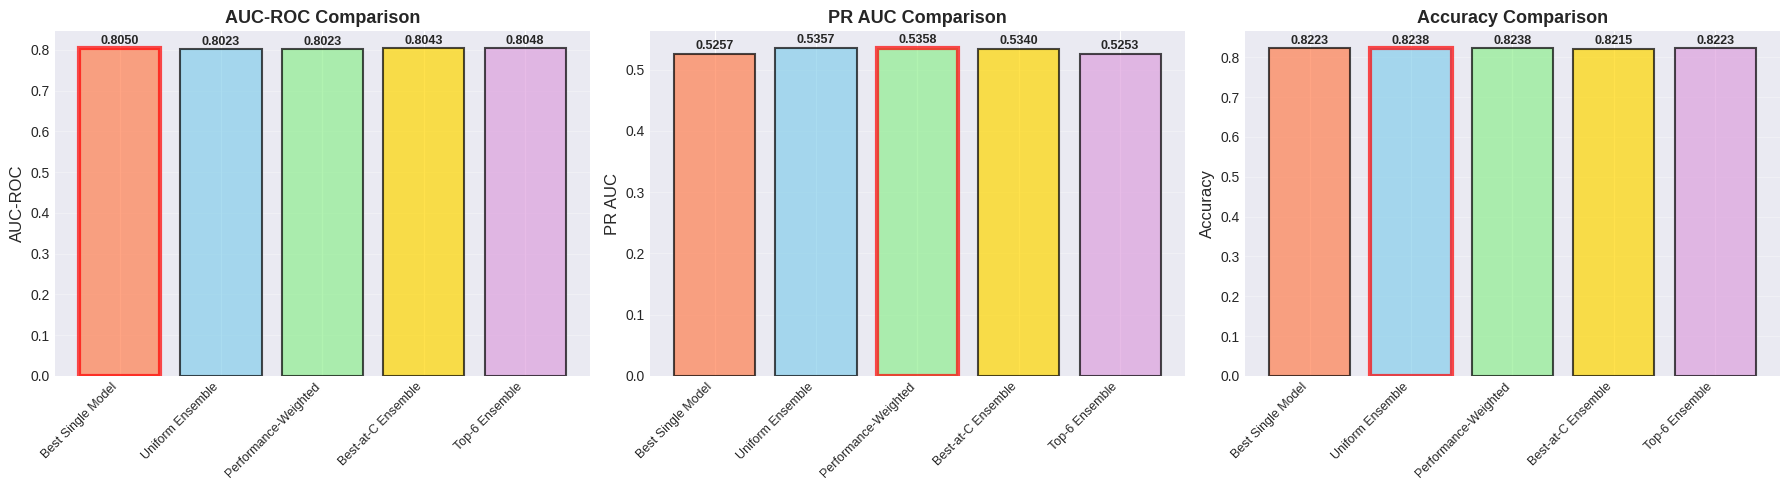

✓ Comparison chart saved to ../results/regularization_conditioned/figures/ensemble_strategies_comparison.png


In [50]:
# Create comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['AUC-ROC', 'PR AUC', 'Accuracy']
colors = ['coral', 'skyblue', 'lightgreen', 'gold', 'plum']

for ax, metric in zip(axes, metrics):
    bars = ax.bar(range(len(comparison_df)), comparison_df[metric], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(comparison_df)))
    ax.set_xticklabels(comparison_df['Approach'], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.003, f'{v:.4f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    # Highlight best
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)

plt.tight_layout()
save_path = FIGURES_DIR / 'ensemble_strategies_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Comparison chart saved to {save_path}")

## 8. ROC and Precision-Recall Curves

In [51]:
# Prepare predictions for all approaches
approaches = {
    'Best Single': models[best_model['model_id']].predict_proba(X_test)[:, 1],
    'Uniform Ensemble': y_pred_uniform,
    'Performance-Weighted': y_pred_weighted,
    'Best-at-C': y_pred_best_at_C,
    f'Top-{K}': y_pred_top_k
}

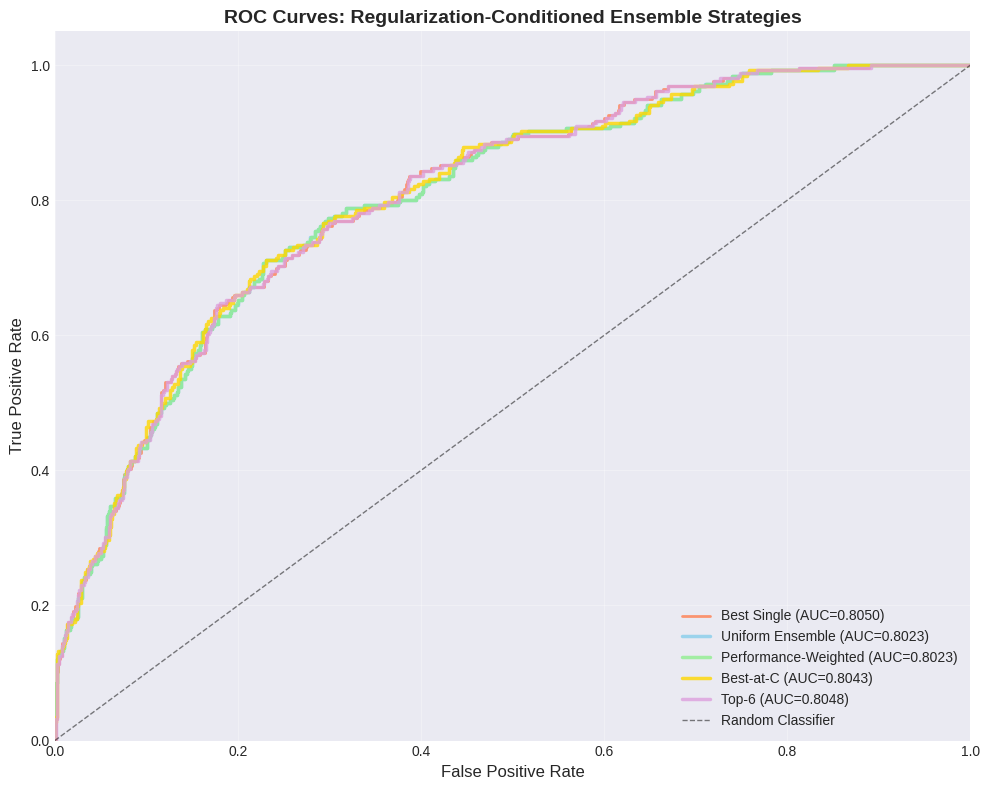

✓ ROC curves saved to ../results/regularization_conditioned/figures/roc_curves_comparison.png


In [52]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

colors_roc = ['coral', 'skyblue', 'lightgreen', 'gold', 'plum']
linestyles = ['-', '-', '-', '-', '-']
linewidths = [2, 2.5, 2.5, 2.5, 2.5]

for idx, (name, y_pred_proba) in enumerate(approaches.items()):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=colors_roc[idx], linestyle=linestyles[idx],
            linewidth=linewidths[idx], alpha=0.8, label=f'{name} (AUC={roc_auc:.4f})')

# Plot diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Regularization-Conditioned Ensemble Strategies', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
save_path = FIGURES_DIR / 'roc_curves_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ ROC curves saved to {save_path}")

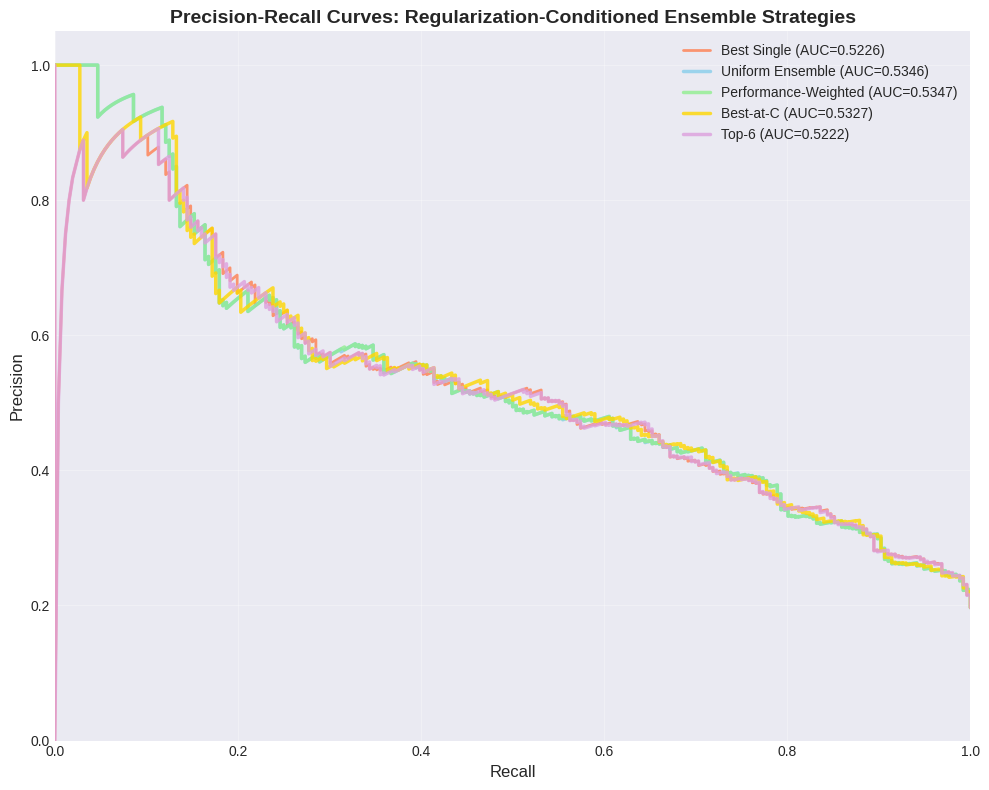

✓ Precision-Recall curves saved to ../results/regularization_conditioned/figures/pr_curves_comparison.png


In [53]:
# Plot Precision-Recall curves
fig, ax = plt.subplots(figsize=(10, 8))

for idx, (name, y_pred_proba) in enumerate(approaches.items()):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc_val = auc(recall, precision)
    ax.plot(recall, precision, color=colors_roc[idx], linestyle=linestyles[idx],
            linewidth=linewidths[idx], alpha=0.8, label=f'{name} (AUC={pr_auc_val:.4f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves: Regularization-Conditioned Ensemble Strategies', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
save_path = FIGURES_DIR / 'pr_curves_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Precision-Recall curves saved to {save_path}")

## 9. Save Results

In [54]:
# Save complete grid results
grid_results_path = RESULTS_DIR / 'scaler_regularization_grid_results.csv'
results_df.to_csv(grid_results_path, index=False)
print(f"✓ Grid results saved to {grid_results_path}")

# Save ensemble comparison
comparison_path = RESULTS_DIR / 'ensemble_strategies_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"✓ Ensemble comparison saved to {comparison_path}")

# Save best-at-C analysis
best_at_C_path = RESULTS_DIR / 'best_scaler_at_each_C.csv'
best_at_C_df.to_csv(best_at_C_path, index=False)
print(f"✓ Best-at-C analysis saved to {best_at_C_path}")

# Save best-C-for-scaler analysis
best_C_path = RESULTS_DIR / 'best_C_for_each_scaler.csv'
best_C_df.to_csv(best_C_path, index=False)
print(f"✓ Best-C analysis saved to {best_C_path}")

# Save pivot table
pivot_path = RESULTS_DIR / 'performance_pivot_table.csv'
pivot_auc.to_csv(pivot_path, index=True)
print(f"✓ Pivot table saved to {pivot_path}")

✓ Grid results saved to ../results/regularization_conditioned/scaler_regularization_grid_results.csv
✓ Ensemble comparison saved to ../results/regularization_conditioned/ensemble_strategies_comparison.csv
✓ Best-at-C analysis saved to ../results/regularization_conditioned/best_scaler_at_each_C.csv
✓ Best-C analysis saved to ../results/regularization_conditioned/best_C_for_each_scaler.csv
✓ Pivot table saved to ../results/regularization_conditioned/performance_pivot_table.csv
